<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Notebook that produces the second look stats we shared with advocates in excel format. Not a spark simulation. Uses data we scraped in October 2021.

In [19]:
# These modules you should install to your computer using the terminal.
# You can do so by 
# 1) typing "python3 -m pip install [module]""; in the cases of the ones below you would
# replace the the [modules] with numpy or pandas or matplotlib or os or sys or
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from functools import partial
import seaborn as sns

# This entire section is dedicated to getting the local modules below to your repository
# since you can't just install it to your computer.
# 1) right click the modules folders in the left side panel
# 2) click "Copy Path"
# 3) replace the string "C:...." below with that 
# 4) replace all the "/" forward slashes with two back slashes like I have below. 
# 5) Then run this code block! You should see no code errors
# sys.path.append("C:\\Users\\annvu\\OneDrive\\Desktop\\GitHub\\stanford-decarceration-collective-ds\\stanford-decarceration-collective-ds\\modules")
# print(sys.path)

#--------

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [6]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../../state_data/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\4150907808.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\4150907808.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\4150907808.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\4150907808.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\4150907808.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\4150907808.py:2: DtypeWarning

In [7]:
scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}

sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)
sorted_data['end_date'] = sorted_data.time_step + sorted_data.LOS.apply(round)

C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\2671540683.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)
C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\2671540683.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['end_date'] = sorted_data.time_step + sorted_data.LOS.apply(round)


In [ ]:
currently_incarcerated = sorted_data[(sorted_data.end_date > 138) & (sorted_data.time_step < 138)]
# 138 is th dsicriminator
len(currently_incarcerated) / len(sorted_data) # this is just saying the fraction of how many people are currently incarcerated

0.029778182450993798

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 4.0000e+00, 1.0000e+00, 3.0000e+00, 7.0000e+00,
        3.0000e+01, 3.5000e+01, 9.7000e+01, 1.4620e+03, 4.3110e+03,
        7.4580e+03, 1.3723e+04, 1.8262e+04, 2.6851e+04, 3.3614e+04,
        3.6692e+04, 3.9418e+04, 3.9566e+04, 4.1186e+04, 4.6976e+04,
        4.7555e+04, 4.6684e+04, 4.8960e+04, 4.5413e+04, 4.2991e+04,
        4.4014e+04, 3.7741e+04, 1.1807e+04, 3.2580e+03, 1.4450e+03,
        8.5300e+02, 5.6800e+02, 4.0000e+02, 3.8200e+02, 3.0100e+02,
        2.5700e+02, 1.8900e+02, 1.3600e+02, 1.1900e+02, 1.1000e+02,
        8.5000e+01, 8.5000e+01, 6.3000e+01, 5.1000e+01, 3.9000e+01,
        3.2000e+01, 2.0000e+01, 3.0000e+01, 2.00

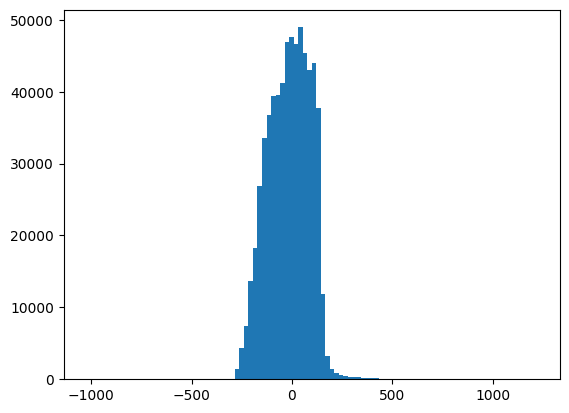

In [25]:
plt.hist(sorted_data.end_date.values,bins=100)

In [26]:
ETC_LEVEL_BY_CRIME = pd.DataFrame({
    'CONSPIRACY': {1:27, 2: 5, 3: 12, 4:7},
    'DRUG_POSSESSION': {1:574, 2:78, 3:177, 4:171},
    'DRUG_SALE': {1:1415, 2:245, 3:629, 4:458},
    'DRUG_OTHER': {1:1989, 2:323, 3:806, 4:629},
    'KIDNAPPING': {1:641, 2:203, 3:430, 4:304},
    'MANSLAUGHTER': {1:175, 2:44, 3:122, 4:96},
    'LARCENY': {1:1289, 2:190, 3:447, 4:591},
    'WEAPON': {1:346, 2:45, 3:100, 4:158},
    'ASSAULT': {1:1391, 2:354, 3:685, 4:728},
    'ROBBERY': {1:1491, 2:488, 3:1049, 4:1014},
    'BURGLARY': {1:740, 2:165, 3:413, 4:476},
    'DWI': {1: 101, 2: 14, 3: 28, 4:24},
    'RAPE': {1:1355, 2:304, 3:917, 4:405},
    'SEX_OFFENSE': {1:343, 2:60, 3:180, 4:80},
    'ARSON': {1:40, 2:13, 3:14, 4:26},
    'FIRST_DEGREE_MURDER': {1:868, 2:288, 3:534, 4:313},
    'SECOND_DEGREE_MURDER': {1:296, 2: 109, 3:224, 4:148},
    'OTHER_MURDER': {1:1327, 2:432, 3:833, 4:498},
    'CAPITAL_MURDER': {1:163, 2:35, 3:75, 4:37}
}).transpose()

LEVEL_ONE = ETC_LEVEL_BY_CRIME[1] / ETC_LEVEL_BY_CRIME.sum(axis=1)

In [ ]:
# times listed in currently_incarcerated and sorted_data are in [months]

11.5

In [33]:
times_to_check = [5 * 12, 10 * 12, 12 * 12, 15 * 12, 18 * 12, 20 * 12, 25 * 12, 30 * 12]# times are in month format

currently_incarcerated['served_so_far'] = 138 - currently_incarcerated.time_step

eligibility_table = pd.DataFrame()
for time in times_to_check:
    eligibility_table[time / 12] = currently_incarcerated[
        currently_incarcerated.served_so_far >= time
    ].groupby('crime_type').count().max(axis=1)
eligibility_table *= scale_factor
eligibility_table = eligibility_table.apply(lambda x: x * LEVEL_ONE[x.name], axis=1)

eligibility_table.loc['total'] = eligibility_table.sum()

eligibility_table.fillna(0)

C:\Users\annvu\AppData\Local\Temp\ipykernel_35988\965025513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currently_incarcerated['served_so_far'] = 138 - currently_incarcerated.time_step


,5,10,12,15,18,20,25,30
crime_type,,,,,,,,
ARSON,18.619830,10.026062,9.309915,6.445326,5.729178,5.013031,4.296884,1.432295
ASSAULT,377.700486,192.150538,142.279406,82.874087,46.204137,35.203152,13.201182,1.466798
BURGLARY,165.520441,82.416817,67.307067,44.642442,22.664625,17.170170,7.554875,5.494454
CAPITAL_MURDER,112.062728,84.047046,75.292145,50.778424,39.397053,22.762742,3.501960,0.000000
CONSPIRACY,37.022709,19.392847,16.748368,13.222396,6.170451,5.288958,0.881493,0.000000
DRUG_OTHER,67.172265,12.373838,9.722302,7.954610,5.303074,4.419228,1.767691,0.883846
DRUG_POSSESSION,130.935608,47.786718,35.362172,16.247484,9.557344,6.690141,4.778672,0.955734
DRUG_SALE,167.246756,42.026108,34.307027,21.441892,17.153513,15.438162,9.434432,4.288378
DWI,14.098024,4.028007,4.028007,4.028007,4.028007,3.021005,2.014003,0.000000


In [24]:
sentence_table = pd.DataFrame()
sentence_lengths = [1 * 12, 3 * 12, 5 * 12, 7 * 12, 10 * 12, 15 * 12, 20 * 12, 25 * 12, 30 * 12, 35 * 12, 40 * 12, 45 * 12, 50 * 12, 55 * 12, 60 * 12, 65 * 12, 70 * 12, 75 * 12, 80 * 12]

for i, start in enumerate(sentence_lengths):
    sentence_group = pd.DataFrame()
    
    if i == (len(sentence_lengths) - 1):
        sentence_group = currently_incarcerated[
            currently_incarcerated.LOS >= start
        ]
    else:
        end = sentence_lengths[i + 1]
        
        sentence_group = currently_incarcerated[
            (currently_incarcerated.LOS >= start) & (currently_incarcerated.LOS < end)
        ]
    
    sentence_table[start/12] = sentence_group.groupby('crime_type').count().max(axis=1)
    
sentence_table.loc['total'] = sentence_table.sum()
sentence_table = sentence_table.fillna(0)
print(len(currently_incarcerated))
sentence_table

19165


,1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80
crime_type,,,,,,,,,,,,,,,,,,,
ARSON,33.0,21.0,7.0,8.0,4.0,4.0,5.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
ASSAULT,758.0,501.0,149.0,217.0,177.0,182.0,54.0,47.0,21.0,22.0,12.0,15.0,2.0,1.0,1.0,1.0,2.0,0.0,7.0
BURGLARY,286.0,188.0,66.0,97.0,32.0,120.0,16.0,11.0,5.0,10.0,8.0,7.0,0.0,1.0,0.0,1.0,1.0,0.0,6.0
CAPITAL_MURDER,2.0,10.0,5.0,15.0,5.0,28.0,19.0,16.0,12.0,14.0,12.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,32.0
CONSPIRACY,72.0,54.0,9.0,36.0,8.0,8.0,3.0,5.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DRUG_OTHER,442.0,275.0,86.0,114.0,24.0,12.0,4.0,3.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
DRUG_POSSESSION,710.0,380.0,93.0,121.0,37.0,32.0,2.0,6.0,2.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DRUG_SALE,680.0,429.0,99.0,227.0,39.0,34.0,6.0,5.0,3.0,8.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
DWI,79.0,32.0,1.0,12.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
# actual_population_july_2021 = 24467# 2021
actual_population_oct_2025 = 22885
error = (len(currently_incarcerated) * scale_factor - actual_population_july_2021) / actual_population_july_2021
error

0.30422767564248004

In [26]:
LEVEL_ONE

CONSPIRACY              0.529412
DRUG_POSSESSION         0.574000
DRUG_SALE               0.515107
DRUG_OTHER              0.530825
KIDNAPPING              0.406210
MANSLAUGHTER            0.400458
LARCENY                 0.512118
WEAPON                  0.533128
ASSAULT                 0.440469
ROBBERY                 0.368877
BURGLARY                0.412486
DWI                     0.604790
RAPE                    0.454545
SEX_OFFENSE             0.517345
ARSON                   0.430108
FIRST_DEGREE_MURDER     0.433350
SECOND_DEGREE_MURDER    0.380952
OTHER_MURDER            0.429450
CAPITAL_MURDER          0.525806
dtype: float64

In [27]:
currently_incarcerated.LOS.median() / 12

np.float64(4.485)